<a href="https://colab.research.google.com/github/cweiqiang/wq.github.io/blob/main/Analysing_ESG_Documents_(micro_course).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Welcome to Activity 3 and 4 of the micro-course!

In this activity, you will be building an ESG report classifier using the BERT transformer model. 

Here are the steps that we will be taking throughout this micro-course:
1. Install the relevant libraries
2. Upload a list of exemplars
3. Create a numerical representation (embeddings) of the exemplars
4. Create a numerical representation of the example text
5. Calculate the similarity between the example text and exemplars

Without further ado, let's get started! 

---

**Note**

If you have not watched the "how-to-use-google-colab" video, please watch the video in the next cell.

In [ ]:
#@title Google Colab Demo Video
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/GuDHAgfIFWQ" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

# Installing and importing libraries

In Python programming, the use of relevant libraries helps us to achieve our goals faster. There are many Python libraries that complete different tasks.
In our task today, we will be installing and importing some Machine Learning libraries to help us.

Some examples include:

1. Transformers (It allows us to use models from the Hugging Face model hub)
2. NumPy (It allows us to work with large, multi-dimensional arrays and matrices)
3. Pandas (It offers data structures and operations for manipulating numerical tables and time series. It allows us to work with CSV files easily)
4. Scikit-learn (Scikit-learn is a software machine learning library for the Python language. We will be using its similarity metrics)

---

**Instructions**

Run cells 1 and 2 to install and import relevant libraries into Google Colab

In [ ]:
#@title 1. Run cell to install relevant libraries
! pip install transformers

In [ ]:
#@title 2. Run cell to import relevant libraries
import numpy as np
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import json

# Hugging Face The BERT Family

In this activity, we will be using the BERT model from the Hugging Face Models library.

Hugging Face is most notable for its Transformers library built for natural language processing applications and its platform that allows users to share machine learning models and datasets.

BERT, short for Bidirectional Encoder Representations from Transformers, is a Machine Learning (ML) model for natural language processing. It was developed in 2018 by researchers at Google AI Language and serves as a solution to many language tasks, such as sentiment analysis and named entity recognition. You can read more about the BERT model at https://huggingface.co/blog/bert-101.

---

When a sentence/paragraph is passed into the BERT model, a numerical representation (embeddings) is generated in the last hidden layer before the classification head (that does the classification).

When we study the BERT model architecture, we understand that a [CLS] token in the last hidden layer contains the context of the sentence. This [CLS] token will be instrumental for us to compare the similarity between two texts.

If you do not understand this at this moment, what you need to know are two things:
1. When we pass an input sentence/paragraph into the BERT model, we want to get the [CLS] token in the last hidden layer
2. We will use the [CLS] tokens to run similarity calculations on

---

**Instructions**

Run cell 3 with "nbroad/ESG-BERT" as the model_to_load.


In [ ]:
#@title 3. Choose your model for the drop-down list

from transformers import BertTokenizer, BertModel
import torch
from torch import nn

model_to_load = 'nbroad/ESG-BERT' #@param ["nbroad/ESG-BERT", "bert-base-cased", "bert-large-cased"]
tokenizer = BertTokenizer.from_pretrained(model_to_load)
model = BertModel.from_pretrained(model_to_load)

Since we will be reusing some code, we will write some functions that can be reused. The following functions were written:

1. A function to obtain the [CLS] token from the BERT model as a numerical representation (embeddings)
2. A function to calculate the similarity of two texts (more about that later!)
3. A function to convert all exemplars into numerical representation (embeddings)
4. A function that loads numerical representations in a csv file
5. A function that batch outputs similarity scores between reference text and all exemplar embeddings

---

**Instructions**
Run cell 4 to create all the functions

In [ ]:
#@title 4. All functions required

def obtain_cls_token(tokenizer, model, text):
    '''
    Returns the [CLS] token embeddings of the text provided

            Parameters:
                    tokenizer: The tokenizer loaded from the model checkpoint
                    model: The model loaded from the model checkpoint
                    text: Text string to generate the embeddings from

            Returns:
                    embeddings: A numpy array of the [CLS] token embeddings
    '''

    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input, output_hidden_states=True)
    embeddings = output.last_hidden_state.detach()[:,0,:].numpy()

    return embeddings

def calculate_cosine_sim(reference_embeddings, comparison_embeddings):
    '''
    Calculates the cosine similarity between reference and comparison embeddings

            Parameters:
                    reference_embeddings: The numpy array of the embeddings of the reference text
                    comparison_embeddings: The numpy array of the embeddings of the comparison text

            Returns:
                    cosine: A cosine similarity score
    '''

    cosine = cosine_similarity(reference_embeddings, comparison_embeddings)

    cosine = round(cosine[0][0],2)

    return cosine

def create_examplar_embeddings(csv_path, tokenizer, model):
    '''
    Creates a json file of all embeddings of exemplar texts

            Parameters:
                    csv_path: The path to the csv file containing the exemplar texts
                    tokenizer: The tokenizer loaded from the model checkpoint
                    model: The model loaded from the model checkpoint
    '''

    df = pd.read_csv(csv_path)

    embeddings_dataset = []

    # loop through rows and get embeddings
    for index, row_data in df.iterrows():
        title = row_data[0]
        text = row_data[1]

        embeddings = obtain_cls_token(tokenizer, model, text)

        # Append embeddings and titles into embeddings_dataset
        embeddings_dataset.append([title,embeddings])

        # Create json file
        json_dict = {}

        for item in embeddings_dataset:
            json_dict[item[0]] = item[1].tolist()

    out_file_name = "reference_embeddings.json"

    out_file = open(out_file_name, "w")

    json.dump(json_dict, out_file, indent = 6)

    out_file.close()

    print(f"Embeddings created and stored as JSON as '{out_file_name}'")


def get_reference_embeddings(reference_embeddings_json_path):
    '''
    Returns an array of exemplar labels and their embeddings

            Parameters:
                    reference_embeddings_json_path: The path to the json file containing the exemplar embeddings

            Returns:
                    full_array: An array containing the exemplar labels and a numpy array of their [CLS] token embeddings
    '''

    # Opening reference embeddings JSON file
    with open(reference_embeddings_json_path, encoding='utf-8') as f:
        data = json.load(f)

    # Convert data to array
    full_array = []

    for key in data:
        full_array.append([key, data[key]])

    return full_array

def get_similarity_scores(comparison_text, full_array, tokenizer, model):
    '''
    Generates the cosine similarity scores of the comparison text against the exemplars embeddings

            Parameters:
                    comparison_text: Text string of the comparison text
                    full_array: An array containing the exemplar labels and a numpy array of their [CLS] token embeddings
                    tokenizer: The tokenizer loaded from the model checkpoint
                    model: The model loaded from the model checkpoint

            Returns:
                    output_array: An array of labels and their respective cosine similarity scores
                    highest_prob_title: A string of the highest probability label
                    highest_prob_title_score: A float of the highest probability label
                    scores_array_np: An array of cosine similarity scores
    '''

    output_array = []
    scores_array = []

    comparison_embeddings = obtain_cls_token(tokenizer, model, comparison_text)

    for array_item in full_array:
        reference_embeddings = np.array(array_item[1])
        cosine_sim_output = calculate_cosine_sim(reference_embeddings, comparison_embeddings)
        scores_array.append(cosine_sim_output)
        output_array.append([array_item[0], cosine_sim_output])

    # Get the topic with the highest score
    scores_array_np = np.array(scores_array)
    max_index = np.argmax(scores_array)
    highest_prob_label = full_array[max_index][0]
    highest_prob_label_score = output_array[max_index][1]

    return output_array, highest_prob_label, highest_prob_label_score, scores_array_np

Once we have written our functions, it is time for us to turn our exemplars into numerical representations (embeddings). 

---

**Instructions**
- Please ensure that you have uploaded "Categories and Exemplars.csv" into the Google Colab Files Directory
- Run cell 5 to create the numerical representations (embeddings)

In [ ]:
#@title 5. Create reference embedddings

create_examplar_embeddings("Categories and Exemplars.csv", tokenizer, model)

# Similiarity Measures

Now it is time for us to compare texts from ESG documents with our reference embeddings.

To simulate this, we will manually extract any paragraph from an ESG document of our choice and compare its similarity with all the exemplars.

However, because not all BERT models are trained to classify the text into the 26 categories, we have to look for another method to compare its similarity. 

We have already done that by generating a numerical representation (embeddings) of each exemplar by extracting the [CLS] token of the last hidden layer.

Now, we can compare the embeddings of the extracted text with the exemplars. There are many similarity measures out there, but the popular one used in Natural Language Processing (NLP) is **Cosine Similarity**.

Cosine similarity is a measure of similarity between two sequences of numbers. The sequence of numbers is represented as vectors and cosine similarity calculates the cosine of the angle between them. Proportional vectors have a cosine similarity of 1 and opposite vectors have a similarity of -1. In other words, if two texts are exactly the same, it has a value of one. If the meaning is exactly the opposite, it should give us a value of -1.*

*You might find that this is not always true, especially when the "meaning" is not captured accurately.

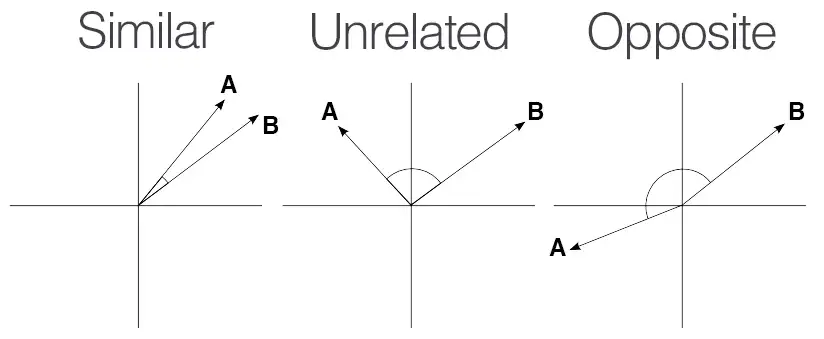

[Source: pyimagesearch]

---

**Instructions**
1. Extract text from a PDF / create your own sentence and key it in the "comparison_text" field in Cell 6. 
2. Run cell 6

In [ ]:
#@title 6. Compare text with reference embeddings

comparison_text = 'In fiscal year 2019, we reduced our comprehensive carbon footprint for the fourth consecutive year\u2014down 35 percent compared to 2015, when Apple\u2019s carbon emissions peaked, even as net revenue increased by 11 percent over that same period. In the past year, we avoided over 10 million metric tons from our emissions reduction initiatives\u2014like our Supplier Clean Energy Program, which lowered our footprint by 4.4 million metric tons. ' #@param {type:"string"}

json_file_path = 'reference_embeddings.json' #@param {type:"string"}

full_array = get_reference_embeddings(json_file_path)

output_scores_array, most_probable, max_score, scores_array = get_similarity_scores(comparison_text, full_array, tokenizer, model)

print("Scores generated.\n")
print("Run the next few cells to print out the data.")

In Activity 2, you might have realised that there will always be irrelevant texts. However, the model is not trained on categorising non-examples. Additionally, our current similarity metric simply tells us how similar a text is to the exemplars; it does not indicate the relevance of the text.

One way to circumvent the issue is to set a tolerance value. If none of the similarity calculations gives a value above the tolerance value, the text will be classified as irrelevant.

---


**Instructions**
1. Adjust the tolerance value
2. Run cells 7 to 9

In [ ]:
#@title 7. Adjust the tolerance value

tolerance = 0.75 #@param {type:"slider", min:0, max:1, step:0.01}

In [ ]:
#@title 8. Run this cell to get the most probable data and its score 

if max_score >= tolerance:
  print(f"{most_probable}: {max_score}")
else:
  print("None of the options gave cosine similarity values greater than the tolerance value. Hence, this text is irrelevant.")

In [ ]:
#@title 9. Run this cell to get the full array of cosine similarity scores
for item in output_scores_array:
  print(f"{item[0]}: {item[1]}")

Congratulations!

You have now built your first ESG text classifier using similarity metrics!